Raw CSV files acquired from (https://data.medicare.gov/data/inpatient-rehabilitation-facility-compare).

In [169]:
import pandas as pd

In [170]:
conditions = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - Conditions.csv')
general_info = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - General Information.csv')
provider_data = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - Provider data.csv')
national_data = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - National data.csv')

In [171]:
provider_data

,CMS Certification Number (CCN),Facility Name,Address Line 1,Address Line 2,City,State,Zip Code,County Name,PhoneNumber,CMS Region,Measure Code,Score,Footnote,Start Date,End Date
0,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_001_01_ADJ_RATE,0.7,NaN,04/01/2016,03/31/2017
1,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_001_01_DENOMINATOR,2259,NaN,04/01/2016,03/31/2017
2,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_002_01_DENOMINATOR,Not Available,4,10/01/2016,03/31/2017
3,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_002_01_OBS_RATE,Not Available,4,10/01/2016,03/31/2017
4,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_CI_LOWER,0.151,NaN,04/01/2016,03/31/2017
5,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_CI_UPPER,2.972,NaN,04/01/2016,03/31/2017
6,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_COMP_PERF,No Different than the National Benchmark,NaN,04/01/2016,03/31/2017
7,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_DOPC_DAYS,1568,NaN,04/01/2016,03/31/2017
8,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_ELIGCASES,2.223,NaN,04/01/2016,03/31/2017
9,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_NUMERATOR,2,NaN,04/01/2016,03/31/2017


Let's start by finding out how many of the providers here are missing any data at all.

In [172]:
#Get total number of unique CCNs
total_ccns = len(provider_data["CMS Certification Number (CCN)"].unique())

#Check if there's any missing data for each CCN
missing_data_ccns = []
for ccn in provider_data["CMS Certification Number (CCN)"].unique():
    subset = provider_data.loc[provider_data["CMS Certification Number (CCN)"] == ccn]
    if subset["Score"].str.contains("Not Available").any():
        missing_data_ccns.append(ccn)
        
print("Number of facilities with missing data: ", len(missing_data_ccns))
print((float(len(missing_data_ccns)) / float(total_ccns)) * 100, "% of all facilities missing data.")

Number of facilities with missing data:  1192
100.0 % of all facilities missing data.


Well that's reassuring. Every single facility is missing a value for at least one field.

We can start by looking at individual metrics and moving from there. Let's start by looking at the rate of patient readmission.

In [173]:
#Select all rows that measure the number of stays and hte patient readmission rate
readmission_rates = provider_data.loc[
    (provider_data["Measure Code"] == "I_007_01_RSRR") | 
    (provider_data["Measure Code"] == "I_007_01_VOLUME")]

In [174]:
#Find all CCNs we want to filter out
filtered_ccns = []
for ccn in readmission_rates["CMS Certification Number (CCN)"].unique():
    #This is funky; just says if either of our two values for that CCN is "Not Available",
    #We'll drop that particular CCN altogether.
    if readmission_rates.loc[readmission_rates["CMS Certification Number (CCN)"] == ccn]["Score"].str.contains("Not Available").any():
        filtered_ccns.append(ccn)

        

print(len(readmission_rates.loc[readmission_rates["Score"].str.contains("Not Available")]),
      "out of a possible ", total_ccns, "facilities.")

275 out of a possible  1192 facilities.


I feel comfortable just dropping those facilities; it does account for about 23% of the dataset, which is a lot, but it won't kill us.

In [175]:
#Drop providers without readmission rate
readmission_rates = readmission_rates.loc[~(readmission_rates["Score"].str.contains("Not Available"))]

In [176]:
#Convert readmission rates to numeric values
readmission_rates["Score"] = readmission_rates["Score"].apply(pd.to_numeric)
readmission_rates.describe()

,Zip Code,CMS Region,Score
count,2109.000000,2109.000000,2109.000000
mean,51922.667141,5.240398,251.521679
std,26988.402353,2.173359,412.269217
min,674.000000,1.000000,5.000000
25%,30033.000000,4.000000,13.360000
50%,50309.000000,5.000000,17.000000
75%,75482.000000,6.000000,329.000000
max,99519.000000,10.000000,6393.000000


So at each end of the spectrum, we have a minimum readmission rate of 10.9% and a maximum of 15.84%. Is this in any way connected to the number of patients that each facility has to care for?

In [177]:
import numpy as np

#Reformat provider_data so that each row is a facility and its constituent measures
datadict = dict([(measure, pd.Series([])) for measure in provider_data["Measure Code"].unique()])
datadict = {**datadict,**{"CMS Certification Number (CCN)" : pd.Series([])}}


#Really inefficient, but there's not a great way of doing this as far as I can see
facility_data = provider_data.groupby(provider_data["CMS Certification Number (CCN)"])
for name, group in facility_data:
    for measure in group["Measure Code"].unique():
        score = group.loc[group["Measure Code"] == measure]["Score"]
        if score.iloc[0].lower() == "not available":
            score = pd.Series([np.nan])
        datadict[measure] = datadict[measure].append(score, ignore_index=True)
        datadict["CMS Certification Number (CCN)"] = datadict["CMS Certification Number (CCN)"].append(pd.Series(name), ignore_index=True)


In [186]:
facility_data = pd.DataFrame(datadict)

We're going to change **I_006_01_COMP_PERF**, **I_007_01_COMP_PERF**, **I_014_01_COMP_PERF** and **I_015_01_COMP_PERF** as follows so that we can treat them as numerical values:
- Worse than the National Benchmark --> -1
- No Different than the National Benchmark --> 0
- Better than the National Benchmark --> 1
with appropriate changes to text values as appropriate (see the function definition below).

In [187]:
def benchmark_manipulation(txt, axis):
    '''
    Want to translate the text values to discrete
    numerical values so that they're easier to work with.
    '''
    if txt == 'No Different than the National Benchmark' or txt == 'No Different from the National Benchmark' or txt == 'No Different than the National Rate':
            return 0
    elif txt == 'Worse than the National Benchmark' or txt == 'Worse than the National Rate':
        return -1
    elif txt == 'Better than the National Benchmark' or txt == 'Better than the National Rate':
        return 1
    else:
        return np.nan


facility_data['I_006_01_COMP_PERF'] = facility_data['I_006_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_007_01_COMP_PERF'] = facility_data['I_007_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_014_01_COMP_PERF'] = facility_data['I_014_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_015_01_COMP_PERF'] = facility_data['I_015_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)

#Change over all values to numeric
for measure in provider_data["Measure Code"].unique():
    facility_data[measure] = facility_data[measure].apply(pd.to_numeric)

Great, all our data is now in the dataframe and properly cleaned. I'm going to pare down the number of columns we're visualizing so that we just have ones with values we're interested in finding connections between.

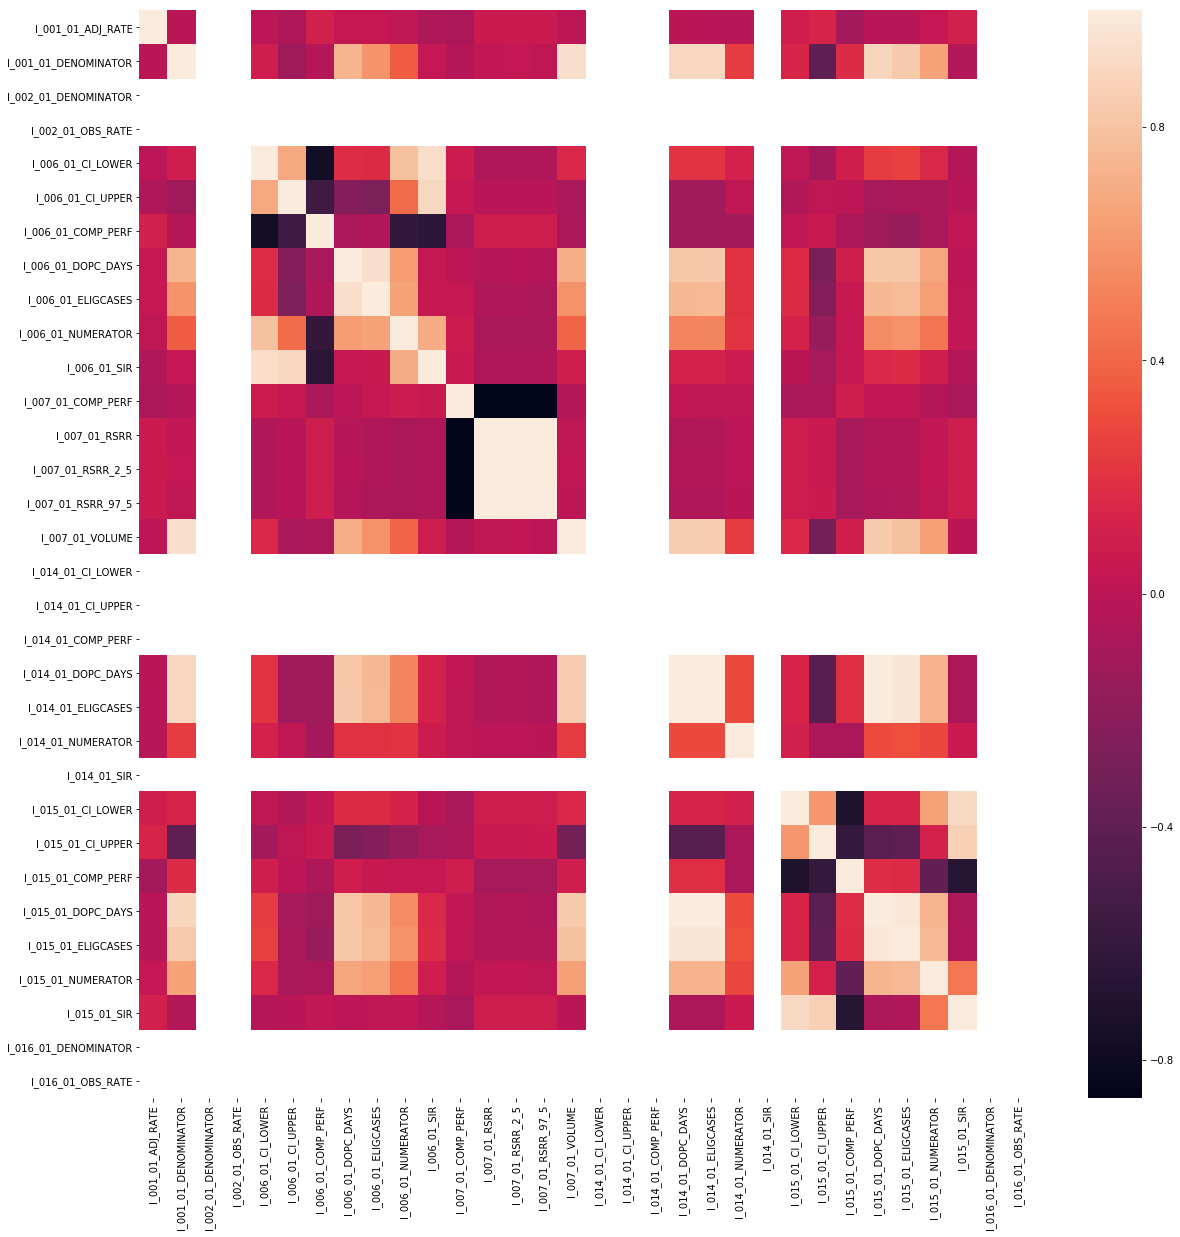

In [195]:
#Chop down the data we want to use for the heat map visualization
from copy import copy
vis_data = copy(facility_data)

#Produce correlation heat map
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
vis_data_corr = vis_data.corr()
sns.heatmap(facility_data_corr, 
            ax=ax,
            xticklabels=vis_data_corr.columns.values,
            yticklabels=vis_data_corr.columns.values)